# Interacting with our SQL Database

This is a notebook introducing you to some code that I have written to access, save, and plot data obtained from the ACME logging database. This takes advantage of some code in `./code/database_access.py` and relies on a `pyodbc` database connection via an SQL server client.

In [1]:
%matplotlib inline

from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.append('./code')
from database_access import DatabaseAccess, load

### Connecting to the Database

The `DatabaseAccess` object creates a connection to the logging database and houses the `pyodbc` connection objects for the `LoggingConfigSQL` database and `LoggingLogData` database. In addition, there are a series of methods that are particular to our database structure that facilitate easier interactions with the database.

In order to connect to the database, you must specify the IP address of the server. In this case Gandalf is located at `25.70.187.150` on the ACME VPN.

In [2]:
db = DatabaseAccess(server='25.70.187.150')

please enter the database password: ········
LoggingConfigSQL connection open
LoggingLogData connection open


The `logging_channels` method accesses the database and provides the full `LogChannelDetails` table in a pandas Dataframe. Below is a sample of that table.

In [3]:
db.logging_channels().head(2)

,LogChannelClassName,LogChannelGroupName,LogChannelID,LogChannelInfo,ParameterTypeName,RoomName,UnitName
LogChannelName,,,,,,,
FG1x,Interaction Region,Fluxgate Magnetometers,1,Bartington Mag-03 Fluxgate Magnetometer Channel,Magnetic Field,LISE G14,mG
FG1y,Interaction Region,Fluxgate Magnetometers,2,Bartington Mag-03 Fluxgate Magnetometer Channel,Magnetic Field,LISE G14,mG


You can also grab any other table in full by using the `get_table` method. Here is an example obtaining a list of the lasers in the lab.

In [4]:
db.get_table('LaserDetails', index='LaserName').head(3)

,ComputerName,LaserID,LaserLockName,LaserLockReferenceName,LaserLockReferenceTypeName,LaserTypeName,LogChannelName,RoomName,WavemeterChannel
LaserName,,,,,,,,,
1064 Iodine Clock,No Computer,1,Iodine Modulation Transfer,Iodine Cell,Molecular Line,Nd:YAG,1064 Iodine Clock Wavenumber,Jefferson 162,0
690 Daredevil,G14 Laser Lock Feanor,2,Feanor Lock 1,Feanor Cavity 1,Scanning Cavity,ECDL Homemade,690 Daredevil Wavenumber,LISE G14,10
690 Red Baron,G14 Laser Lock Feanor,3,Feanor Lock 1,Feanor Cavity 1,Scanning Cavity,ECDL Homemade,690 Red Baron Wavenumber,LISE G14,2


### Accessing Data

Use the database command `get_data` to obtain data from logging channels and or groups. This command returns a `TimeSeriesArray` object that includes a `plot` method for simple plotting of the data. This object has a list of `TimeSeries` objects each of which correspond to a particular channel and have a timestamp array `t`, a data array `x`, and a channel properties field `channel`.

Here is an example usage with a single channel - this is the vaccum pressure near the interactions region

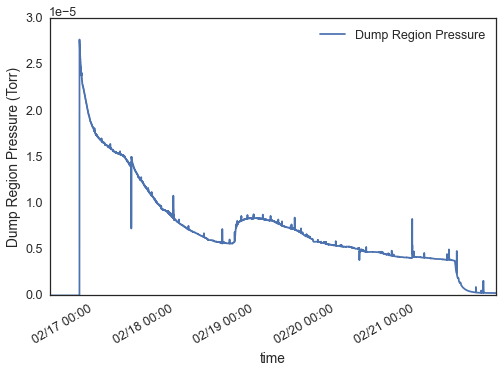

In [25]:
ts = db.get_data('Dump Region Pressure', 
                 start_time=datetime(2016,2,16),
                 end_time=datetime(2016,2,22))
ts.plot()

Here is another example obtaining data from the last week of humidity data

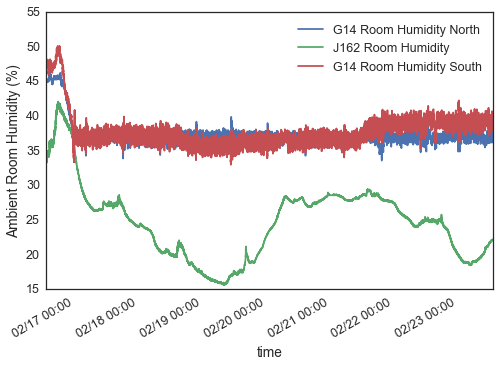

In [20]:
tsa = db.get_data(group='Ambient Room Humidity', duration='1 week')
tsa.plot()

You can save the `TimeSeriesArray` objects to file as `.pkl` files which can be opened with the `load` function. If `load` is not provided a filename, it prompts the user to select a `.pkl` file from within the current working directory. After reloading the object, we can use it just as before - here we provide the example of accessing the array of channels which are included in this object.

In [7]:
tsa.save()
tsa = load()
tsa.channels()

saved: ./data/2016-02-21T18-28_2016-02-21T22-28_Stem_Pressure_Beam_Box_Pressure_Dump_Region_Pressure.pkl
0    ./data/2016-02-21T18-28_2016-02-21T22-28_Stem_...
dtype: object
input an integer corresponding to the file that you would like to load: 0
loaded: ./data/2016-02-21T18-28_2016-02-21T22-28_Stem_Pressure_Beam_Box_Pressure_Dump_Region_Pressure.pkl


['Stem Pressure', 'Beam Box Pressure', 'Dump Region Pressure']

Sometimes you might be using this database access script to access the data, but you might not want to analyze the data in python. Under those circumstances, you may want to use the `save_to_text` function, which saves the data to a tab delimited txt file.

In [8]:
tsa.save_to_text()

saved: ./data/2016-02-21T18-28_2016-02-21T22-28_Stem_Pressure_Beam_Box_Pressure_Dump_Region_Pressure.txt


### Accessing Control State Changes

Above, we grabbed continuous logged data from the database and we plotted and saved it using the `TimeSeriesArray` object. In addition to continuous data, we also log discrete state changes in various experiment parameters that we call **controls**. We can perform analogous operations of grabbing and plotting this type of data using the `TimeSeriesStates` object which is provided by the database method `get_control_data`.

Here is an example of getting all control state change data during the last 2 weeks from all controls within `LogControlClass='Beam Source'` (designated by keyword group).

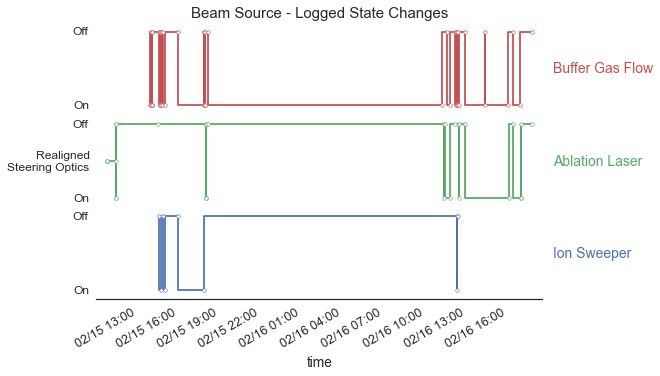

In [3]:
tss = db.get_control_data(group='Beam Source', 
                          duration='2 weeks')
tss.plot(label_fontsize=12)

Here is another example obtaining all data from the last week - here some style modifications were made upon plotting so that the state labels didn't overlap

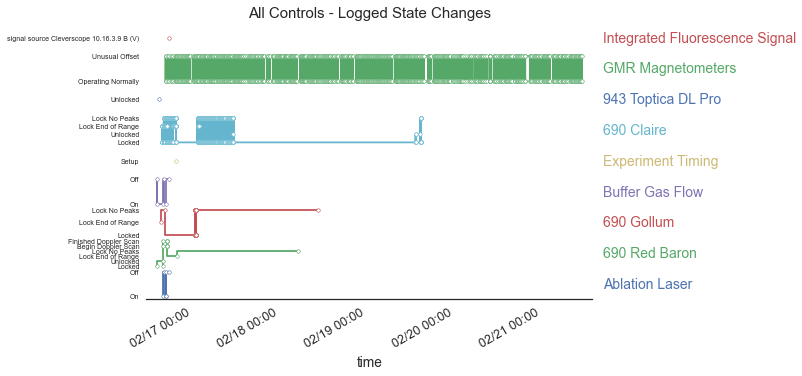

In [7]:
tss = db.get_control_data(duration='1 week')
tss.plot(wrap_length=100, label_fontsize=7)

## Issuing General SQL Commands

You can also issue general SQL commands and obtain responses in a pandas dataframe as follows:

In [8]:
db.sql_command("""SELECT * FROM information_schema.tables""", 
               database="LoggingLogData")

,TABLE_CATALOG,TABLE_NAME,TABLE_SCHEMA,TABLE_TYPE
0,LoggingLogData,LogChannelData,dbo,BASE TABLE
1,LoggingLogData,LogControlStateData,dbo,BASE TABLE
2,LoggingLogData,LogLabNotes,dbo,BASE TABLE
3,LoggingLogData,DopplerScanData,dbo,BASE TABLE
4,LoggingLogData,DopplerScans,dbo,BASE TABLE
5,LoggingLogData,Header,dbo,BASE TABLE
6,LoggingLogData,AblationMirrorPositioning,dbo,BASE TABLE
7,LoggingLogData,LogProgramErrors,dbo,BASE TABLE


### Finished? Close the Connection

Its good practice to close the database connection when you are done accessing data:

In [9]:
db.close()

database connection closed
